<a href="https://colab.research.google.com/github/Cyazar/fastai/blob/main/C2opy_of_inference_dynamic_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook shows how to run inference with the [MAXIM family of models](https://github.com/google-research/maxim) from [TensorFlow Hub](https://tfhub.dev/sayakpaul/collections/maxim/1). MAXIM family of models share the same backbone for performing: denoising, dehazing, deblurring, deraining, and enhancement. You can know more about the public MAXIM models from [here](https://github.com/google-research/maxim#results-and-pre-trained-models).

This notebook allows you to run dynamic shaped images unlike [this one](https://github.com/sayakpaul/maxim-tf/blob/main/notebooks/inference.ipynb).

## Select a checkpoint

In [1]:
task = "Deblurring"  # @param ["Denoising", "Dehazing_Indoor", "Dehazing_Outdoor", "Deblurring", "Deraining", "Enhancement", "Retouching"]

model_handle_map = {
    "Denoising": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_denoising_sidd/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Denoising/input/0003_30.png",
    ],
    "Dehazing_Indoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-indoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/0003_0.8_0.2.png",
    ],
    "Dehazing_Outdoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-outdoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/1444_10.png",
    ],
    "Deblurring": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_gopro/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deblurring/input/1fromGOPR0950.png",
        '/content/maxim_S-3_deblur',
        'maxim_s-3_deblurring_gopro_1.tar.gz'
    ],
    "Deraining": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_deraining_raindrop/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deraining/input/15.png",
    ],
    "Enhancement": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
    "Retouching": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_fivek/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
}

model_handle = model_handle_map[task]
ckpt =  model_handle[2]
print(f"TF-Hub handle: {ckpt}.")

TF-Hub handle: /content/maxim_S-3_deblur.


For deblurring, there are other checkpoints too:

- https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_realblur_r/1
- https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_realblur_j/1
- https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_reds/1


## Imports

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

In [3]:
import os
if os.path.exists('/content/maxim-tf') == False:
  %cd /content
  !git clone https://github.com/sayakpaul/maxim-tf.git
  %cd /content/maxim-tf
  !pip install -r requirements.txt

In [4]:
#!ls
#!mkdir maxim_s-2_enhancement_fivek_1
#!tar -xf maxim_s-2_enhancement_fivek_1.tar.gz -C maxim_s-2_enhancement_fivek_1
%cd /content

if os.path.exists(model_handle[2]) == False:
  !mkdir model_handle[2]
  !tar -xf model_handle[3] -C model_handle[2]

/content


In [5]:
%cd /content/maxim-tf

/content/maxim-tf


In [6]:
import sys

sys.path.append("..")

from create_maxim_model import Model
from maxim.configs import MAXIM_CONFIGS

TODO: When the repository is public, clone it and use accordingly.

## Fetch the input image based on the task

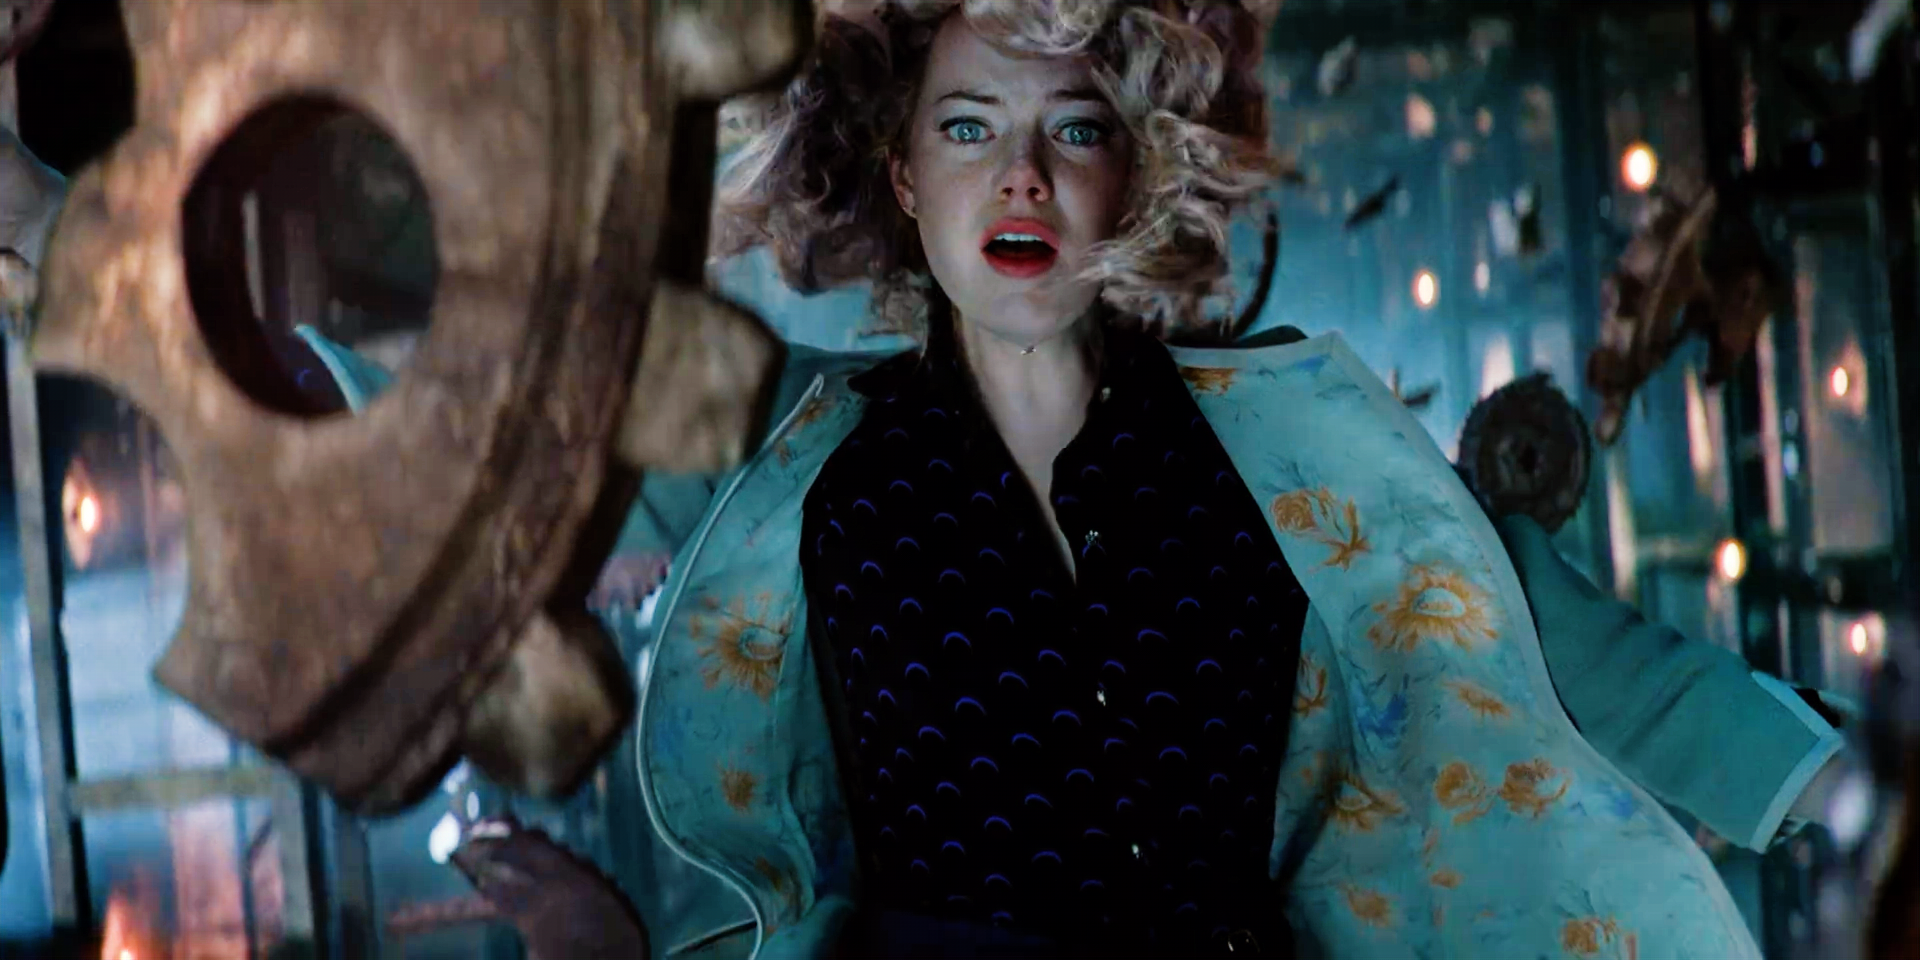

In [7]:
image_url = model_handle[1]
image_path = '/content/enhance_emma.png'#tf.keras.utils.get_file(origin=image_url)
Image.open(image_path)

## Load the model

In [8]:
filename = model_handle[2]
_MODEL = tf.keras.models.load_model(filename)

## Preprocessing utilities

Based on [this official script](https://github.com/google-research/maxim/blob/main/maxim/run_eval.py).

In [9]:
def mod_padding_symmetric(image, factor=64):
    """Padding the image to be divided by factor."""
    height, width = image.shape[0], image.shape[1]
    height_pad, width_pad = ((height + factor) // factor) * factor, (
        (width + factor) // factor
    ) * factor
    padh = height_pad - height if height % factor != 0 else 0
    padw = width_pad - width if width % factor != 0 else 0
    image = tf.pad(
        image, [(padh // 2, padh // 2), (padw // 2, padw // 2), (0, 0)], mode="REFLECT"
    )
    return image


def make_shape_even(image):
    """Pad the image to have even shapes."""
    height, width = image.shape[0], image.shape[1]
    padh = 1 if height % 2 != 0 else 0
    padw = 1 if width % 2 != 0 else 0
    image = tf.pad(image, [(0, padh), (0, padw), (0, 0)], mode="REFLECT")
    return image


def process_image(image: Image):
    input_img = np.asarray(image) / 255.0
    height, width = input_img.shape[0], input_img.shape[1]

    # Padding images to have even shapes
    input_img = make_shape_even(input_img)
    height_even, width_even = input_img.shape[0], input_img.shape[1]

    # padding images to be multiplies of 64
    input_img = mod_padding_symmetric(input_img, factor=64)
    input_img = tf.expand_dims(input_img, axis=0)
    return input_img, height, width, height_even, width_even


def init_new_model(input_img):
    print(ckpt)
    variant = ckpt.split("/")[-1].split("_")[1]
    print(variant)
    configs = MAXIM_CONFIGS.get(variant)
    configs.update(
        {
            "variant": "S-2",
            "dropout_rate": 0.0,
            "num_outputs": 3,
            "use_bias": True,
            "num_supervision_scales": 3,
        }
    )  # From https://github.com/google-research/maxim/blob/main/maxim/run_eval.py#L45-#L61
    configs.update({"input_resolution": (input_img.shape[1], input_img.shape[2])})
    new_model = Model(**configs)
    new_model.set_weights(_MODEL.get_weights())
    return new_model

To make the model operate on images of arbitrary shapes here's what we're doing:

* Loading the initial pre-trained model into `_MODEL`.
* Initializing a separate instance of MAXIM based on the configs and spatial resolutions of the input image.
* Populating the params of this newly initialized model with that of `_MODEL`. 

All of it is handled in `init_new_model()`. 

## Run predictions

In [10]:
# Based on https://github.com/google-research/maxim/blob/main/maxim/run_eval.py
def infer(image_path: str):
    image = Image.open(image_path).convert("RGB")
    preprocessed_image, height, width, height_even, width_even = process_image(image)
    new_model = init_new_model(preprocessed_image)

    preds = new_model.predict(preprocessed_image)
    if isinstance(preds, list):
        preds = preds[-1]
        if isinstance(preds, list):
            preds = preds[-1]

    preds = np.array(preds[0], np.float32)

    new_height, new_width = preds.shape[0], preds.shape[1]
    h_start = new_height // 2 - height_even // 2
    h_end = h_start + height
    w_start = new_width // 2 - width_even // 2
    w_end = w_start + width
    preds = preds[h_start:h_end, w_start:w_end, :]

    return np.array(np.clip(preds, 0.0, 1.0))

In [ ]:
final_pred_image = infer('/content/enhance_emma.png')

/content/maxim_S-3_deblur
S-3


## Visualize results

In [ ]:
# Based on https://www.tensorflow.org/lite/examples/style_transfer/overview#visualize_the_inputs
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
input_image = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
imshow(input_image, "Input Image")

plt.subplot(1, 2, 2)
imshow(final_pred_image, "Predicted Image")

In [ ]:
from matplotlib.pyplot import imsave
%cd /content/
imsave('deblur_enhance_emma.png', final_pred_image)

In [ ]:
!pwd